In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [2]:
#scrape a single game shots. We will allow users to enter a base url
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id: 16878


In [3]:
#Use requests to get the webpage and BeautifulSoup to parse the page
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [4]:
#get only the shotsData
strings = scripts[1].string

In [5]:
# strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

In [6]:
minute = []
xG = []
result = []
team = []
data_away = data['a']
data_home = data['h']

for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'minute':
            minute.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])
        if key == 'xG':
            xG.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'minute':
            minute.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])
        if key == 'xG':
            xG.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])

In [7]:
col_names = ['minute','xG','result','team']
df = pd.DataFrame([minute,xG,result,team],index=col_names)
df = df.T

In [8]:
df['xG'] = df['xG'].astype(float)
print(df)

   minute        xG       result        team
0      13  0.027047  BlockedShot  Fiorentina
1      14  0.544084         Goal  Fiorentina
2      16  0.065467  MissedShots  Fiorentina
3      36  0.095272  MissedShots  Fiorentina
4      45  0.046602         Goal  Fiorentina
5      50  0.144532    SavedShot  Fiorentina
6      59  0.462506         Goal  Fiorentina
7      69  0.049075  MissedShots  Fiorentina
8      84  0.074104         Goal  Fiorentina
9      95  0.000000      OwnGoal  Fiorentina
10      5  0.064166  MissedShots    AC Milan
11     19  0.015659    SavedShot    AC Milan
12     20  0.028040    SavedShot    AC Milan
13     29  0.056746    SavedShot    AC Milan
14     30  0.073944  BlockedShot    AC Milan
15     33  0.094983    SavedShot    AC Milan
16     34  0.068554  BlockedShot    AC Milan
17     41  0.309207  MissedShots    AC Milan
18     43  0.047550  BlockedShot    AC Milan
19     44  0.047561  MissedShots    AC Milan
20     49  0.081063  MissedShots    AC Milan
21     51 

In [9]:
#now that we have our dataframe set up, we are going to create some lists to plot the different xG values
#4 lists - home and away xg and minutes
#We start these with zero so our charts will start at 0
a_xG = [0]
h_xG= [0]
home=[data_home[0]['h_team']]
a_min = [0]
h_min = [0]
away=[data_home[0]['a_team']]


#this finds our team names from the dataframe. This will only work as long as both teams took a shot
hteam = df['team'].iloc[0]
ateam = df['team'].iloc[-1]

for x in range(len(df['xG'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['minute'][x])
        away.append(data_home[0]['a_team'])
    if df['team'][x]==hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['minute'][x])
        home.append(data_home[0]['h_team'])
        
#this is the function we use to make our xG values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

#this is used to find the total xG. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

[0, '13', '14', '16', '36', '45', '50', '59', '69', '84', '95']
[0, '5', '19', '20', '29', '30', '33', '34', '41', '43', '44', '49', '51', '52', '61', '66', '95', '95']


findfont: Font family ['Andale Mono'] not found. Falling back to DejaVu Sans.


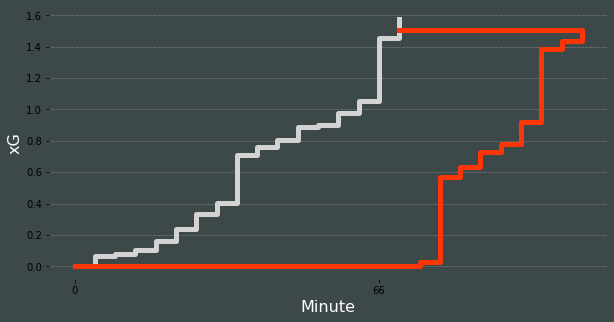

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,5))
fig.set_facecolor('#3d4849')
ax.patch.set_facecolor('#3d4849')

#set up our base layer
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

ax.grid(ls='dotted',lw=.5,color='lightgrey',axis='y',zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
plt.xticks([0,15,30,45,60,75,90])
plt.xlabel('Minute',fontname='Andale Mono',color='white',fontsize=16)
plt.ylabel('xG',fontname='Andale Mono',color='white',fontsize=16)
print(h_min)
print(a_min)
#plot the step graphs
ax.step(x=a_min,y=a_cumulative,color='#d3d3d3',label=ateam,linewidth=5,where='post')
ax.step(x=h_min,y=h_cumulative,color='#fd3607',label=ateam,linewidth=5,where='post')

In [11]:
xG = a_cumulative + h_cumulative
minute = a_min + h_min
teams = away + home

In [12]:
col_names = ['minute','xG','team']
df = pd.DataFrame([minute,xG,teams],index=col_names)
df = df.T
print(df)

   minute        xG        team
0       0         0    AC Milan
1       5  0.064166    AC Milan
2      19  0.079825    AC Milan
3      20  0.107865    AC Milan
4      29  0.164611    AC Milan
5      30  0.238555    AC Milan
6      33  0.333538    AC Milan
7      34  0.402092    AC Milan
8      41    0.7113    AC Milan
9      43   0.75885    AC Milan
10     44  0.806411    AC Milan
11     49  0.887474    AC Milan
12     51  0.902369    AC Milan
13     52  0.980291    AC Milan
14     61   1.05389    AC Milan
15     66  1.455064    AC Milan
16     95  1.496402    AC Milan
17     95  1.574192    AC Milan
18      0         0  Fiorentina
19     13  0.027047  Fiorentina
20     14  0.571132  Fiorentina
21     16  0.636599  Fiorentina
22     36  0.731871  Fiorentina
23     45  0.778473  Fiorentina
24     50  0.923005  Fiorentina
25     59   1.38551  Fiorentina
26     69  1.434586  Fiorentina
27     84   1.50869  Fiorentina
28     95   1.50869  Fiorentina


In [13]:
print(str(int(data_home[0]['season'])+1))
df.to_csv(r'../CSV/xG matchs/'+str(data_home[0]['season'])+'-'+str(int(data_home[0]['season'])+1)+'/xG_'+str(data_home[0]['h_team'])+'-'+str(data_home[0]['a_team'])+'.csv', index = False)

2022


In [14]:
print(data)

{'h': [{'id': '442898', 'minute': '13', 'result': 'BlockedShot', 'X': '0.8819999694824219', 'Y': '0.4420000076293945', 'xG': '0.02704734168946743', 'player': 'Dusan Vlahovic', 'h_a': 'h', 'player_id': '7084', 'situation': 'FromCorner', 'season': '2021', 'shotType': 'Head', 'match_id': '16878', 'h_team': 'Fiorentina', 'a_team': 'AC Milan', 'h_goals': '4', 'a_goals': '3', 'date': '2021-11-20 19:45:00', 'player_assisted': 'Cristiano Biraghi', 'lastAction': 'Cross'}, {'id': '442899', 'minute': '14', 'result': 'Goal', 'X': '0.9309999847412109', 'Y': '0.49200000762939455', 'xG': '0.5440844893455505', 'player': 'Alfred Duncan', 'h_a': 'h', 'player_id': '1474', 'situation': 'FromCorner', 'season': '2021', 'shotType': 'LeftFoot', 'match_id': '16878', 'h_team': 'Fiorentina', 'a_team': 'AC Milan', 'h_goals': '4', 'a_goals': '3', 'date': '2021-11-20 19:45:00', 'player_assisted': None, 'lastAction': 'None'}, {'id': '442900', 'minute': '16', 'result': 'MissedShots', 'X': '0.8769999694824219', 'Y': '